https://github.com/arviz-devs/simuk/issues/35

## Prepare Notebook

In [1]:
from collections.abc import Callable
from typing import Any, Protocol, cast

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
from arviz_base import from_dict
from arviz_plots.plots import plot_ecdf_pit
from jax import Array, random
from jax.typing import ArrayLike
from joblib import Parallel, delayed
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoGuide, AutoNormal
from numpyro.infer.elbo import ELBO
from numpyro.optim import _NumPyroOptim
from simuk.sbc import SBC
from tqdm import tqdm
from typing_extensions import runtime_checkable
from xarray import DataTree

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Specify Model

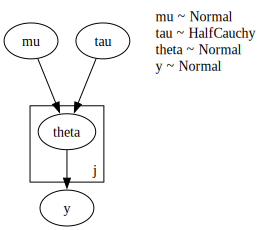

In [2]:
y = jnp.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = jnp.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
j = 8


def model(j: int, sigma: ArrayLike, y: ArrayLike | None = None) -> None:
    mu = numpyro.sample("mu", dist.Normal(loc=0, scale=5))
    tau = numpyro.sample("tau", dist.HalfCauchy(scale=5))

    with numpyro.plate("j", j):
        theta = numpyro.sample("theta", dist.Normal(loc=mu, scale=tau))

    numpyro.sample("y", dist.Normal(loc=theta, scale=sigma), obs=y)


numpyro.render_model(
    model,
    model_args=(j, sigma),
    render_distributions=True,
    render_params=True,
)

## Prior

In [3]:
rng_key, rng_subkey = random.split(key=rng_key)
model_kwargs = {"j": 8, "sigma": sigma}
model_kwargs_all = model_kwargs | {"sigma": sigma, "y": y}

rng_key, rng_subkey = random.split(key=rng_key)
prior_predictive = Predictive(
    model, num_samples=4 * 1_000, return_sites=["mu", "tau", "theta"]
)
prior_samples = prior_predictive(rng_subkey, **model_kwargs)

prior_idata = az.from_dict({k: v[None, ...] for k, v in prior_samples.items()})

## NUTS

In [4]:
nuts_kernel = NUTS(model, target_accept_prob=0.95)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
    progress_bar=False,
)

rng_key, rng_subkey = random.split(key=rng_key)
mcmc.run(rng_subkey, **model_kwargs_all)
nuts_idata = az.from_numpyro(mcmc)

In [5]:
nuts_idata["sample_stats"]["diverging"].sum().item()

44

## SVI

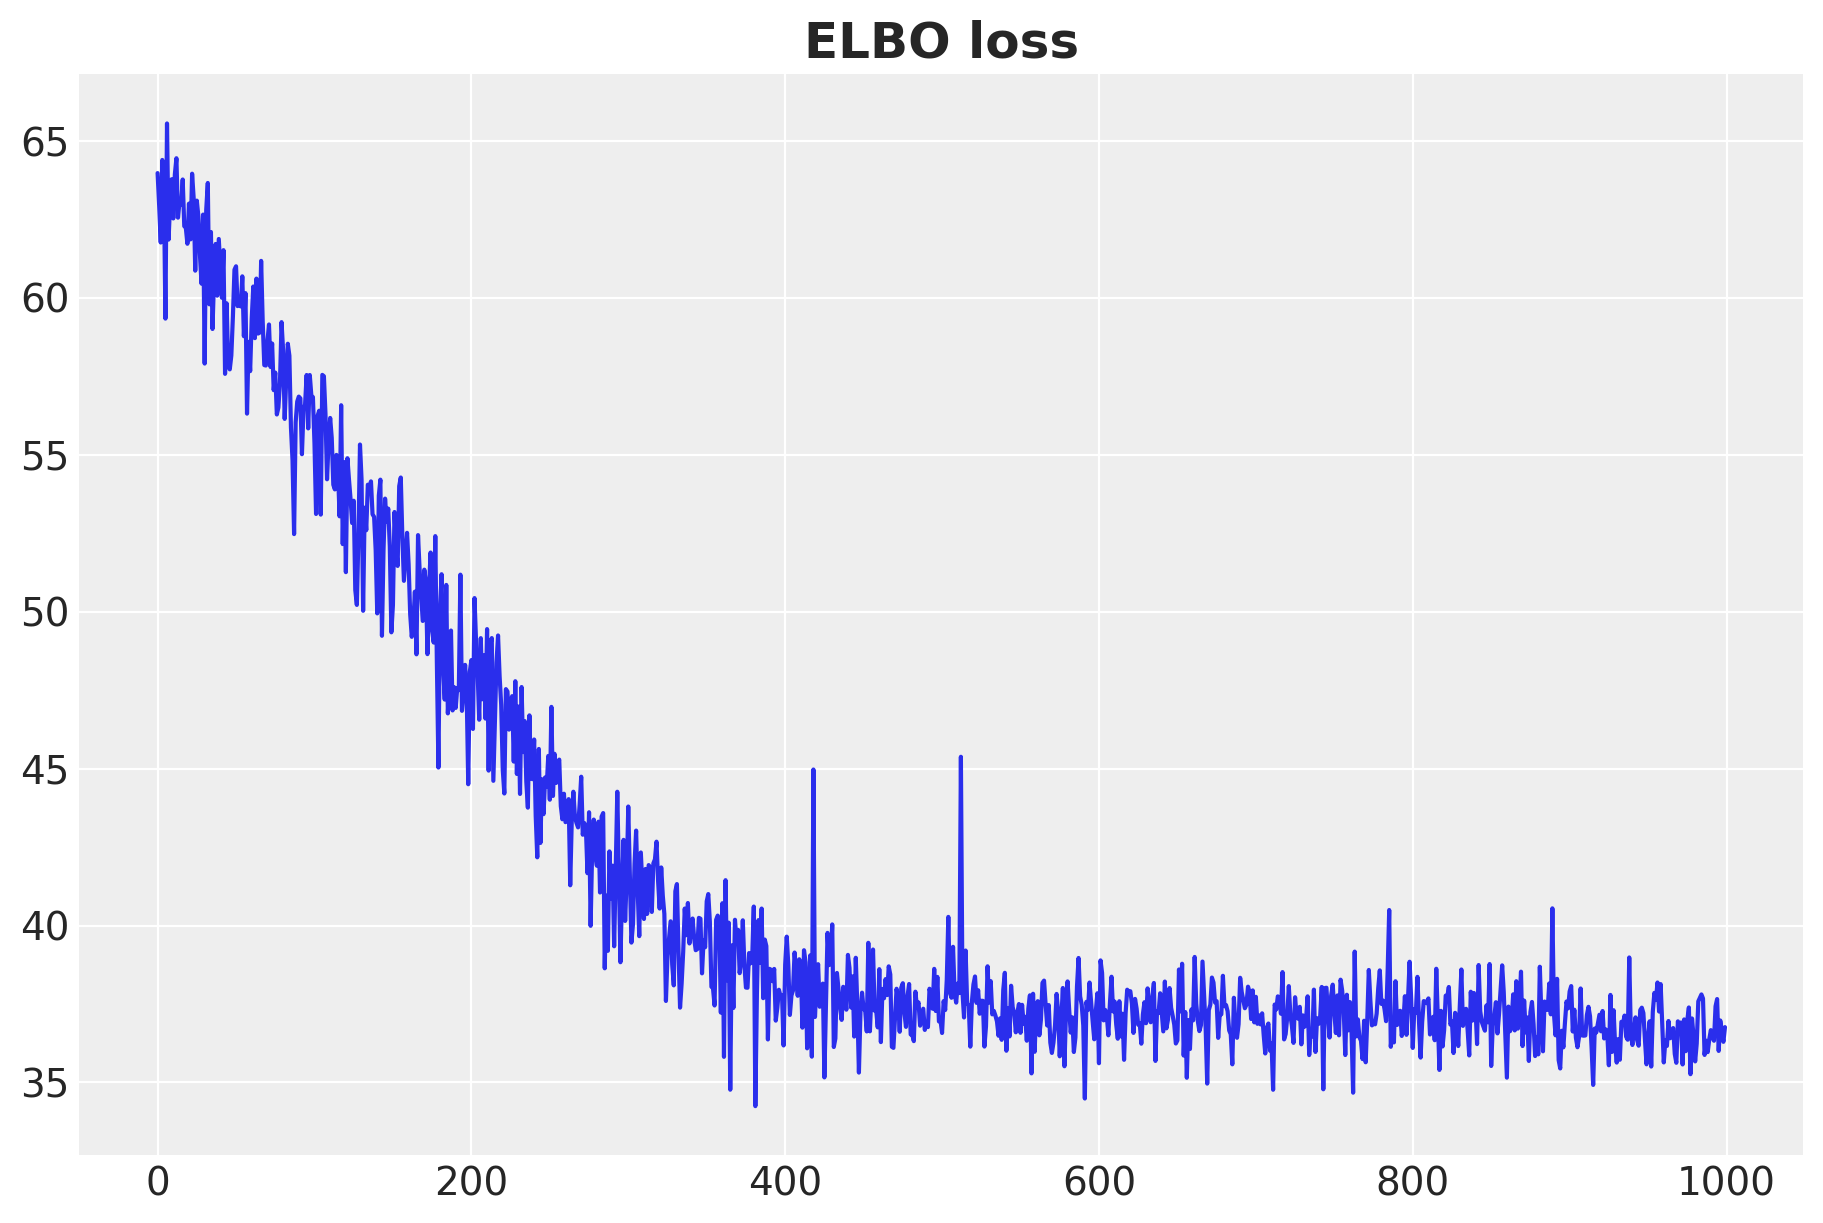

In [6]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.005)
loss = Trace_ELBO(num_particles=3)
num_steps = 1_000
svi = SVI(model, guide, optimizer, loss=loss)

rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    num_steps,
    progress_bar=False,
    **model_kwargs_all,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [7]:
predictive = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=4 * 1_000,
    return_sites=["mu", "tau", "theta"],
)

rng_key, rng_subkey = random.split(key=rng_key)
svi_samples = predictive(rng_subkey, **model_kwargs)
svi_idata = az.from_dict(posterior={k: v[None, ...] for k, v in svi_samples.items()})

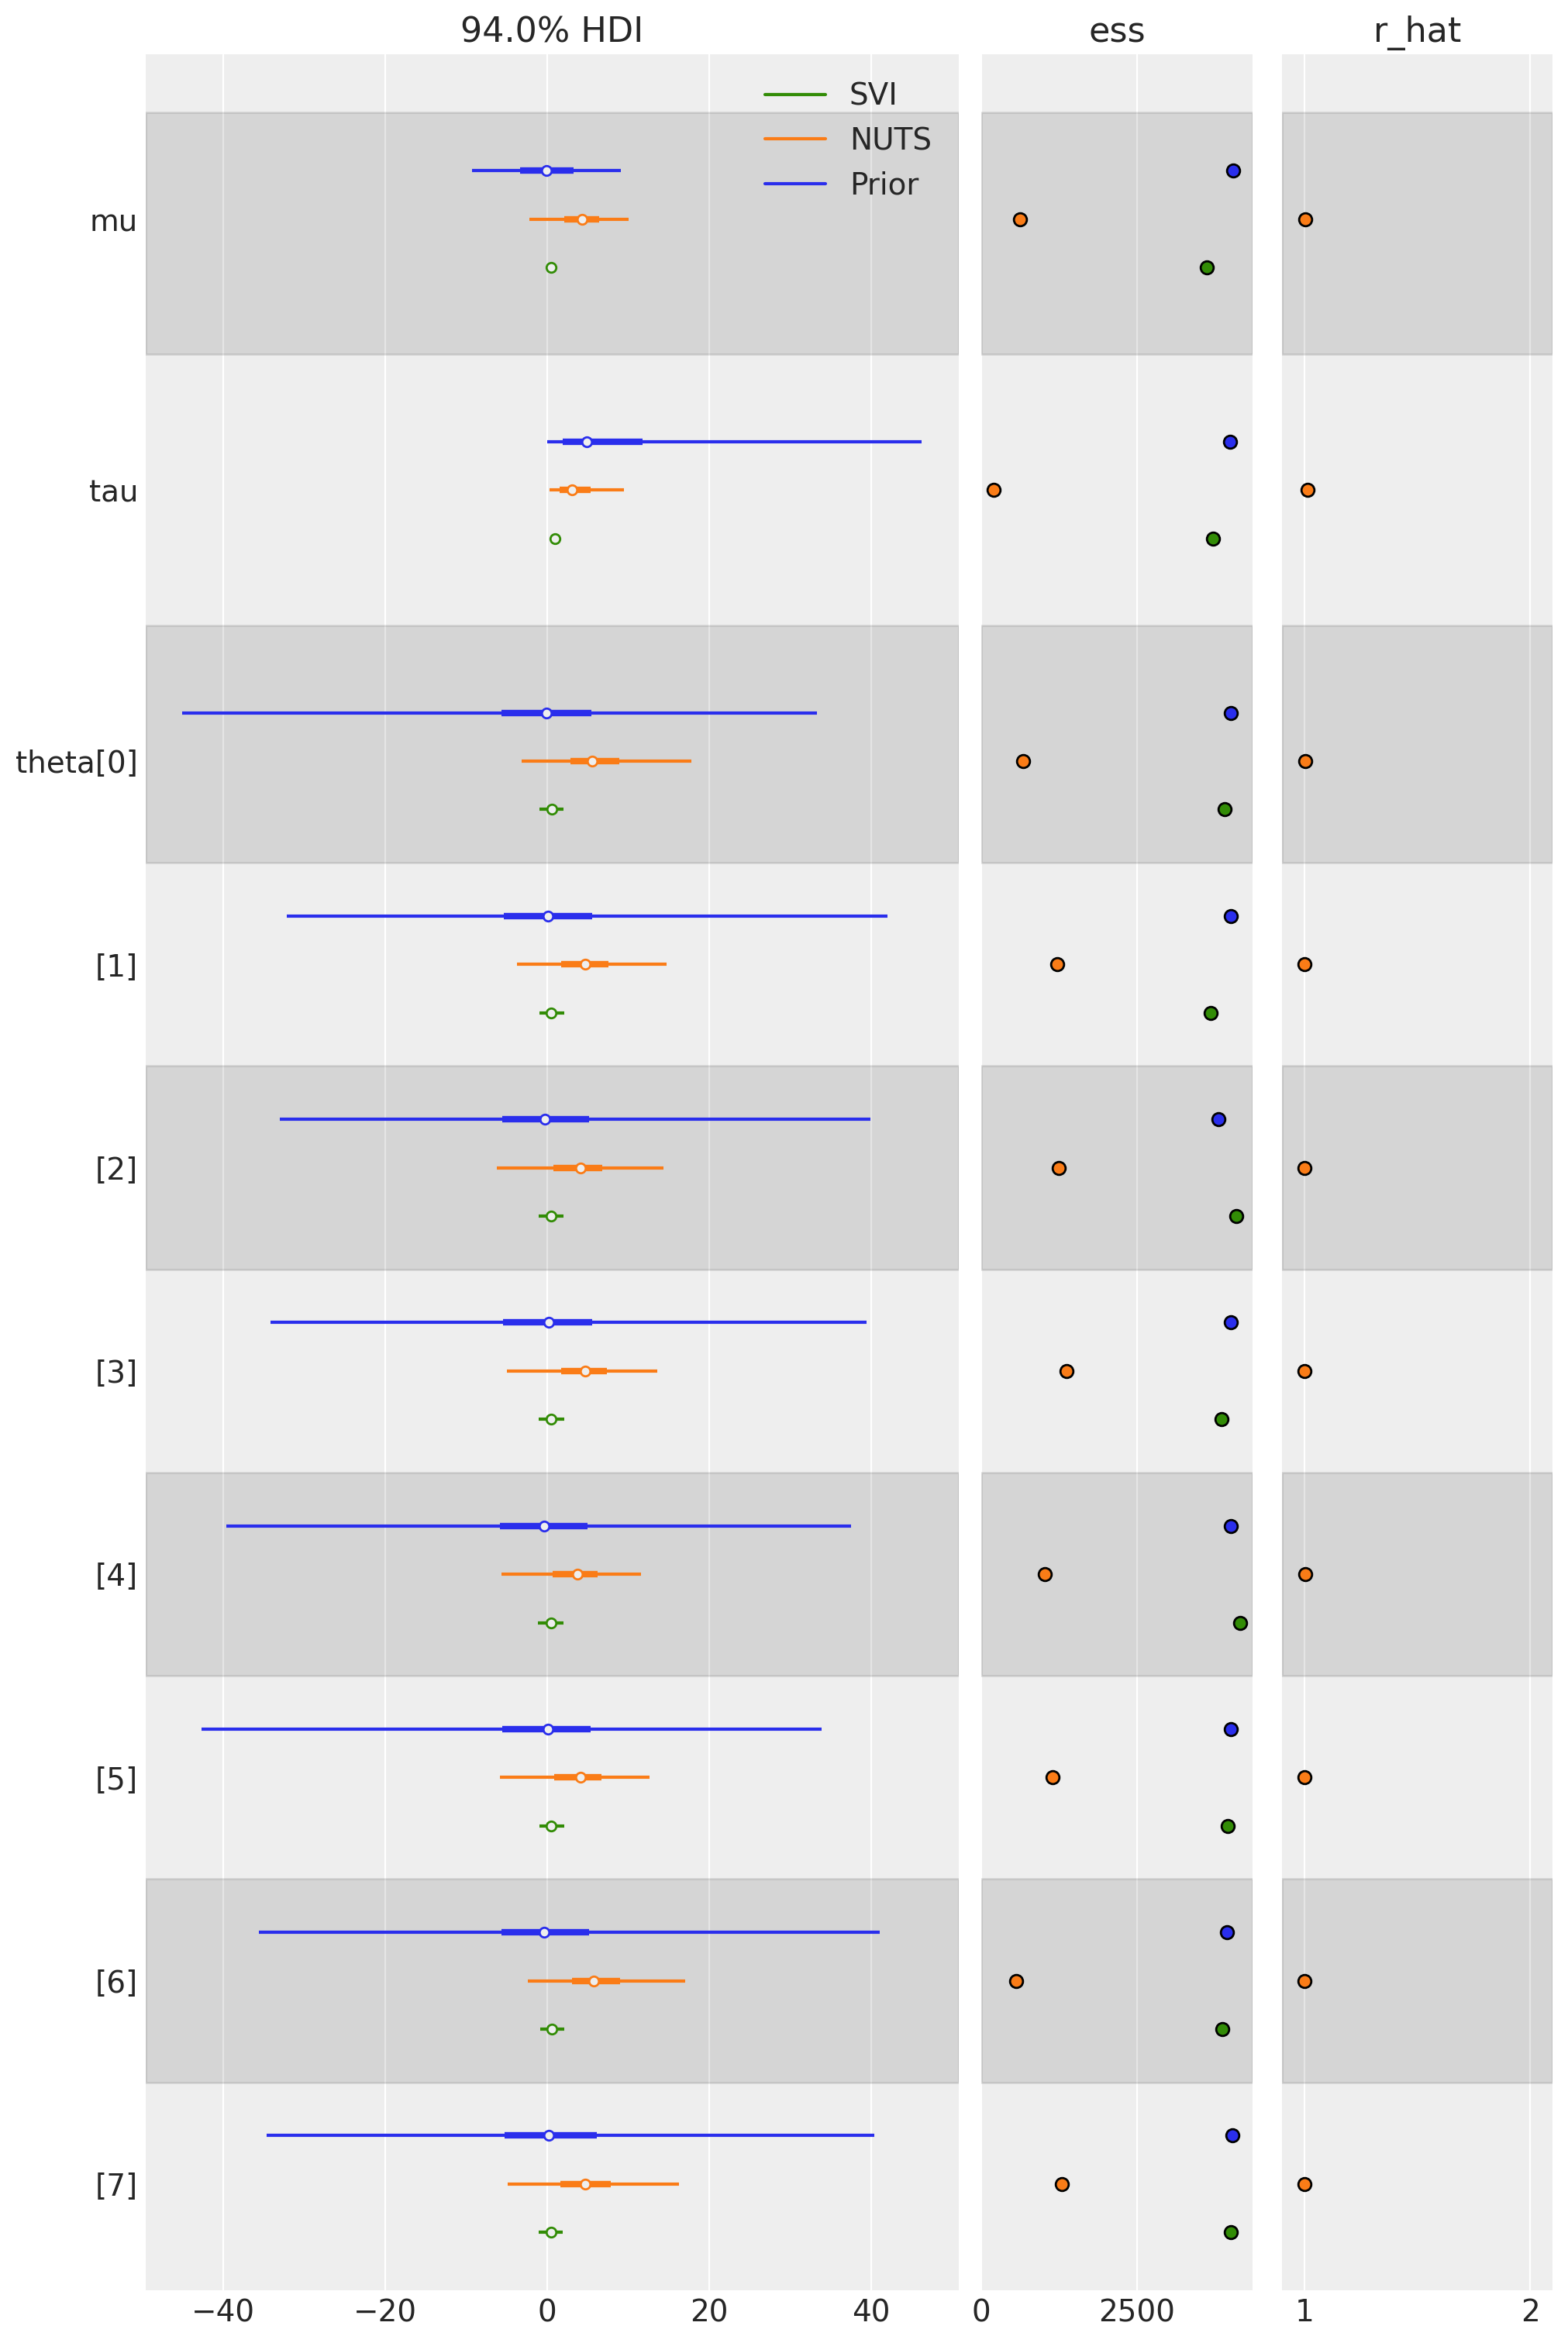

In [8]:
_ = az.plot_forest(
    data=[prior_idata, nuts_idata, svi_idata],
    model_names=["Prior", "NUTS", "SVI"],
    var_names=["mu", "tau", "theta"],
    combined=True,
    ess=True,
    r_hat=True,
)

## Run SBC from Simuk

In [9]:
%%time

nuts_kernel = NUTS(model)

num_simulations = 100

sbc = SBC(
    nuts_kernel,
    sample_kwargs={"num_warmup": 1_000, "num_chains": 4, "num_samples": 1_000},
    num_simulations=num_simulations,
    data_dir={"j": 8, "sigma": sigma, "y": y},
)

sbc.run_simulations()

100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

CPU times: user 2min 46s, sys: 3.09 s, total: 2min 49s
Wall time: 2min 43s


In [10]:
sbc.simulations

<xarray.DataTree>
Group: /
│   Attributes:
│       inferece_library:            numpyro
│       inferece_library_version:    0.18.0
│       modeling_interface:          simuk
│       modeling_interface_version:  0.2.0
└── Group: /prior_sbc
        Dimensions:      (chain: 1, draw: 100, theta_dim_0: 8)
        Coordinates:
          * chain        (chain) int64 8B 0
          * draw         (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
          * theta_dim_0  (theta_dim_0) int64 64B 0 1 2 3 4 5 6 7
        Data variables:
            mu           (chain, draw) int32 400B 104 977 254 788 ... 624 924 259 612
            tau          (chain, draw) int32 400B 522 211 257 106 185 ... 966 215 751 0
            theta        (chain, draw, theta_dim_0) int32 3kB 94 126 114 ... 795 703 659
        Attributes:
            created_at:                 2025-03-25T12:04:31.091634+00:00
            creation_library:           ArviZ
            creation_library_version:   0.5.0
            creation_library_language:  Python

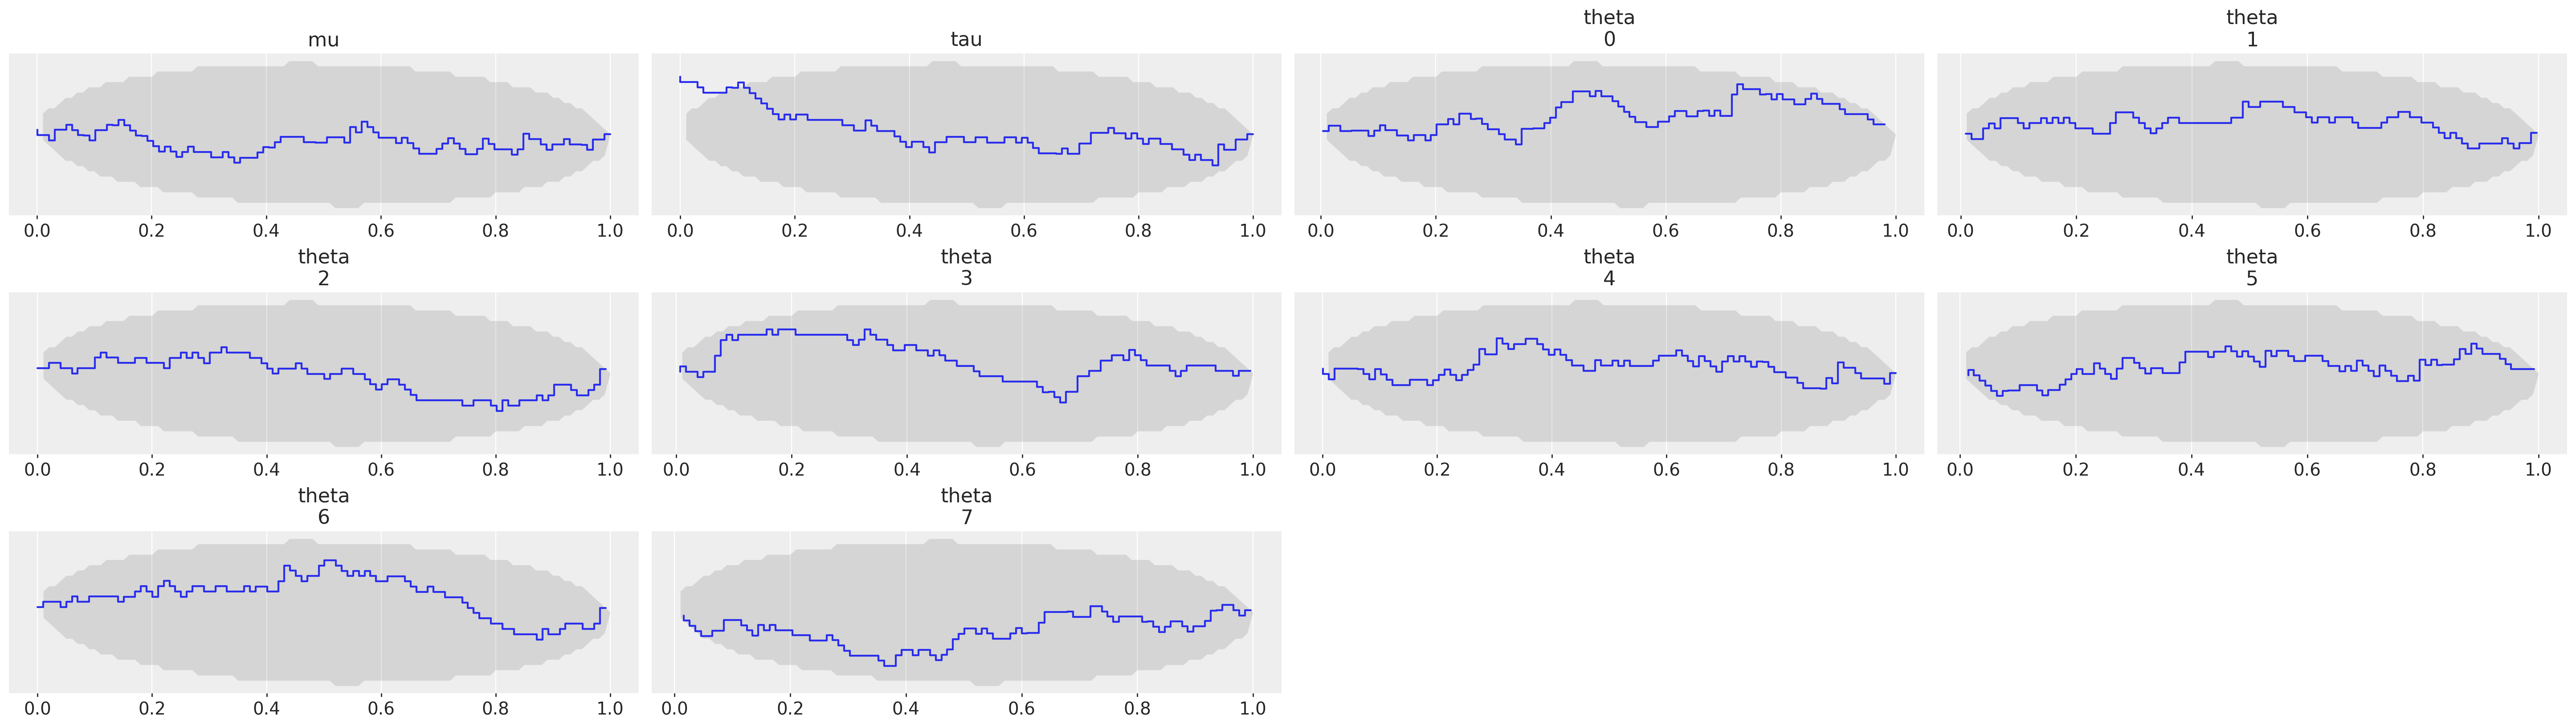

In [11]:
plot_ecdf_pit(
    sbc.simulations, pc_kwargs={"col_wrap": 4}, plot_kwargs={"xlabel": False}
);

##  Extract Variable Types

In [12]:
def extract_numpyro_variable_types(
    rng_key: Array, model: Callable, model_kwargs: dict[str, Any]
) -> tuple[list[str], list[str]]:
    """Extract free and observed variables from a NumPyro model."""
    tr = trace(seed(model, rng_key)).get_trace(**model_kwargs)

    var_names: list[str] = [
        name
        for name, site in tr.items()
        if site["type"] == "sample" and not site.get("is_observed", False)
    ]

    observed_vars: list[str] = [
        name
        for name, site in tr.items()
        if site["type"] == "sample" and site.get("is_observed", False)
    ]

    return var_names, observed_vars


var_names, observed_vars = extract_numpyro_variable_types(
    rng_key, model, model_kwargs_all
)


print(f"Variable names: {var_names}")
print(f"Observed variables: {observed_vars}")

Variable names: ['mu', 'tau', 'theta']
Observed variables: ['y']


## Define Prior Predictive Samples Protocol

In [13]:
@runtime_checkable
class GetPriorPredictiveSamples(Protocol):
    """Get prior predictive samples from the a data generating process."""

    def __call__(
        self,
        num_simulations: int,
        **kwargs: Any,
    ) -> tuple[dict[str, Array], dict[str, Array]]: ...


def _get_prior_predictive_samples(
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict,
    var_names: list[str],
    observed_vars: list[str],
    **predictive_kwargs: dict,
) -> tuple[dict[str, Array], dict[str, Array]]:
    predictive = Predictive(
        model=model, num_samples=num_simulations, **predictive_kwargs
    )
    samples = predictive(rng_key, **model_kwargs)
    prior = {k: v for k, v in samples.items() if k in var_names}
    prior_pred = {k: v for k, v in samples.items() if k in observed_vars}
    return prior, prior_pred


get_prior_predictive_samples: GetPriorPredictiveSamples = cast(
    GetPriorPredictiveSamples, _get_prior_predictive_samples
)

## Define Posterior Samples Protocol

### NUTS

In [14]:
@runtime_checkable
class GetPosteriorSamples(Protocol):
    """Get posterior samples from the a data generating process."""

    def __call__(
        self,
        prior_predictive_draw: dict[str, Array],
        num_simulations: int,
        **kwargs: Any,
    ) -> dict[str, Array]: ...


def _get_posterior_samples_nuts(
    prior_predictive_draw: dict[str, Array],
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict | None = None,
    nuts_kwargs: dict | None = None,
    mcmc_kwargs: dict | None = None,
) -> dict[str, Array]:
    nuts_kernel = NUTS(model, **nuts_kwargs if nuts_kwargs else {})
    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_simulations,
        progress_bar=False,
        **(mcmc_kwargs if mcmc_kwargs else {}),
    )
    mcmc.run(rng_key, **model_kwargs, **prior_predictive_draw)
    return az.from_numpyro(mcmc)["posterior"].sel(chain=0)


get_posterior_samples_nuts: GetPosteriorSamples = cast(
    GetPosteriorSamples, _get_posterior_samples_nuts
)

### SVI

In [15]:
def _get_posterior_samples_svi(
    prior_predictive_draw: dict[str, Array],
    num_simulations: int,
    *,
    rng_key: Array,
    model: Callable,
    model_kwargs: dict,
    guide: AutoGuide,
    optimizer: _NumPyroOptim,
    loss: ELBO,
    num_steps: int,
    svi_kwargs: dict | None = None,
    **predictive_kwargs: dict,
) -> dict[str, Array]:
    svi = SVI(model, guide, optimizer, loss=loss, **(svi_kwargs if svi_kwargs else {}))
    rng_key, rng_subkey = random.split(key=rng_key)
    svi_result = svi.run(
        rng_subkey,
        num_steps,
        progress_bar=False,
        **model_kwargs,
        **prior_predictive_draw,
    )

    predictive = Predictive(
        model=model,
        guide=guide,
        params=svi_result.params,
        num_samples=num_simulations,
        **predictive_kwargs,
    )

    rng_key, rng_subkey = random.split(key=rng_key)
    samples = predictive(rng_subkey, **model_kwargs)

    return az.from_dict(posterior={k: v[None, ...] for k, v in samples.items()})[
        "posterior"
    ].sel(chain=0)


get_posterior_samples_svi: GetPosteriorSamples = cast(
    GetPosteriorSamples, _get_posterior_samples_svi
)

## Simulation Interface

In [16]:
def run_simulation(
    get_prior_predictive_samples: GetPriorPredictiveSamples,
    get_prior_predictive_samples_kwargs: dict[str, Any],
    get_posterior_samples: GetPosteriorSamples,
    get_posterior_samples_kwargs: dict[str, Any],
    var_names: list[str],
    num_simulations: int,
) -> DataTree:
    simulations_complete: int = 0

    prior, prior_pred = get_prior_predictive_samples(
        num_simulations=num_simulations, **get_prior_predictive_samples_kwargs
    )

    simulations: dict[str, list[npt.NDArray]] = {name: [] for name in var_names}

    try:

        def process_simulation(
            idx,
            prior_pred,
            prior,
            var_names,
            get_posterior_samples,
            num_simulations,
            get_posterior_samples_kwargs,
        ):
            prior_predictive_draw = {k: v[idx] for k, v in prior_pred.items()}
            posterior_samples = get_posterior_samples(
                prior_predictive_draw, num_simulations, **get_posterior_samples_kwargs
            )

            results = {}
            for name in var_names:
                results[name] = (
                    (posterior_samples[name] < prior[name][idx]).sum(axis=0).to_numpy()
                )
            return results

        results = Parallel(n_jobs=-1)(
            delayed(process_simulation)(
                idx,
                prior_pred,
                prior,
                var_names,
                get_posterior_samples,
                num_simulations,
                get_posterior_samples_kwargs,
            )
            for idx in tqdm(range(num_simulations))
        )

        for result in results:
            for name in var_names:
                simulations[name].append(result[name])
            simulations_complete += 1

    finally:
        simulations = {
            k: np.stack(v[:simulations_complete])[None, :]
            for k, v in simulations.items()
        }

    return from_dict({"prior_sbc": simulations})

## Run Simulation


### NUTS

In [17]:
%%time

rng_key, rng_subkey_prior, rng_subkey_posterior = random.split(key=rng_key, num=3)

simulations_nuts: DataTree = run_simulation(
    get_prior_predictive_samples=get_prior_predictive_samples,
    get_prior_predictive_samples_kwargs={
        "rng_key": rng_subkey_prior,
        "model": model,
        "model_kwargs": model_kwargs,
        "var_names": var_names,
        "observed_vars": observed_vars,
    },
    get_posterior_samples=get_posterior_samples_nuts,
    get_posterior_samples_kwargs={
        "rng_key": rng_subkey_posterior,
        "model": model,
        "model_kwargs": model_kwargs,
        "nuts_kwargs": {"target_accept_prob": 0.9},
        "mcmc_kwargs": {"num_warmup": 1_000, "num_chains": 4},
    },
    var_names=var_names,
    num_simulations=num_simulations,
)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


CPU times: user 771 ms, sys: 218 ms, total: 989 ms
Wall time: 46.3 s


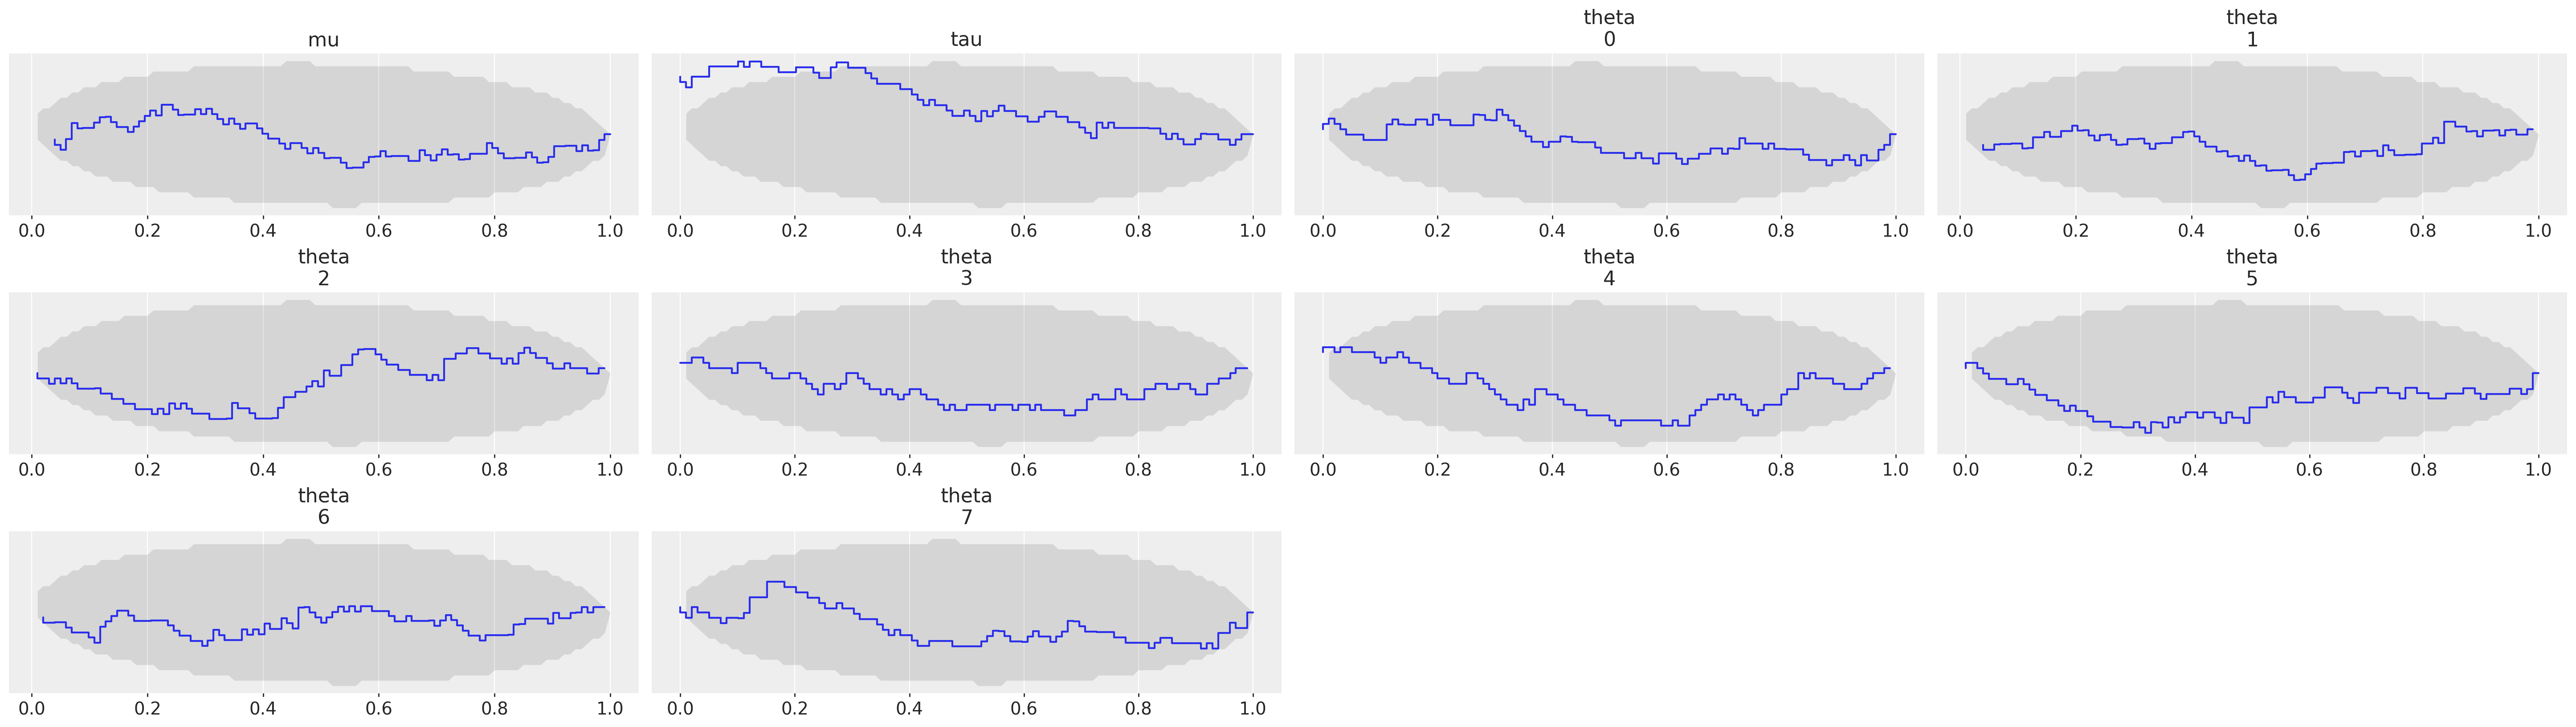

In [18]:
plot_ecdf_pit(
    simulations_nuts,
    pc_kwargs={"col_wrap": 4},
    plot_kwargs={"xlabel": False},
);

### SVI

In [19]:
%%time

rng_key, rng_subkey_prior, rng_subkey_posterior = random.split(key=rng_key, num=3)

simulations_svi: DataTree = run_simulation(
    get_prior_predictive_samples=get_prior_predictive_samples,
    get_prior_predictive_samples_kwargs={
        "rng_key": rng_subkey_prior,
        "model": model,
        "model_kwargs": model_kwargs,
        "var_names": var_names,
        "observed_vars": observed_vars,
    },
    get_posterior_samples=get_posterior_samples_svi,
    get_posterior_samples_kwargs={
        "rng_key": rng_subkey_posterior,
        "model": model,
        "model_kwargs": model_kwargs,
        "guide": AutoNormal(model),
        "optimizer": numpyro.optim.Adam(step_size=0.01),
        "loss": Trace_ELBO(),
        "num_steps": 1_000,
        "return_sites": var_names + observed_vars,
    },
    var_names=var_names,
    num_simulations=num_simulations,
)

 72%|███████▏  | 72/100 [00:14<00:05,  5.44it/s]/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child pro

CPU times: user 1.15 s, sys: 278 ms, total: 1.43 s
Wall time: 39.3 s


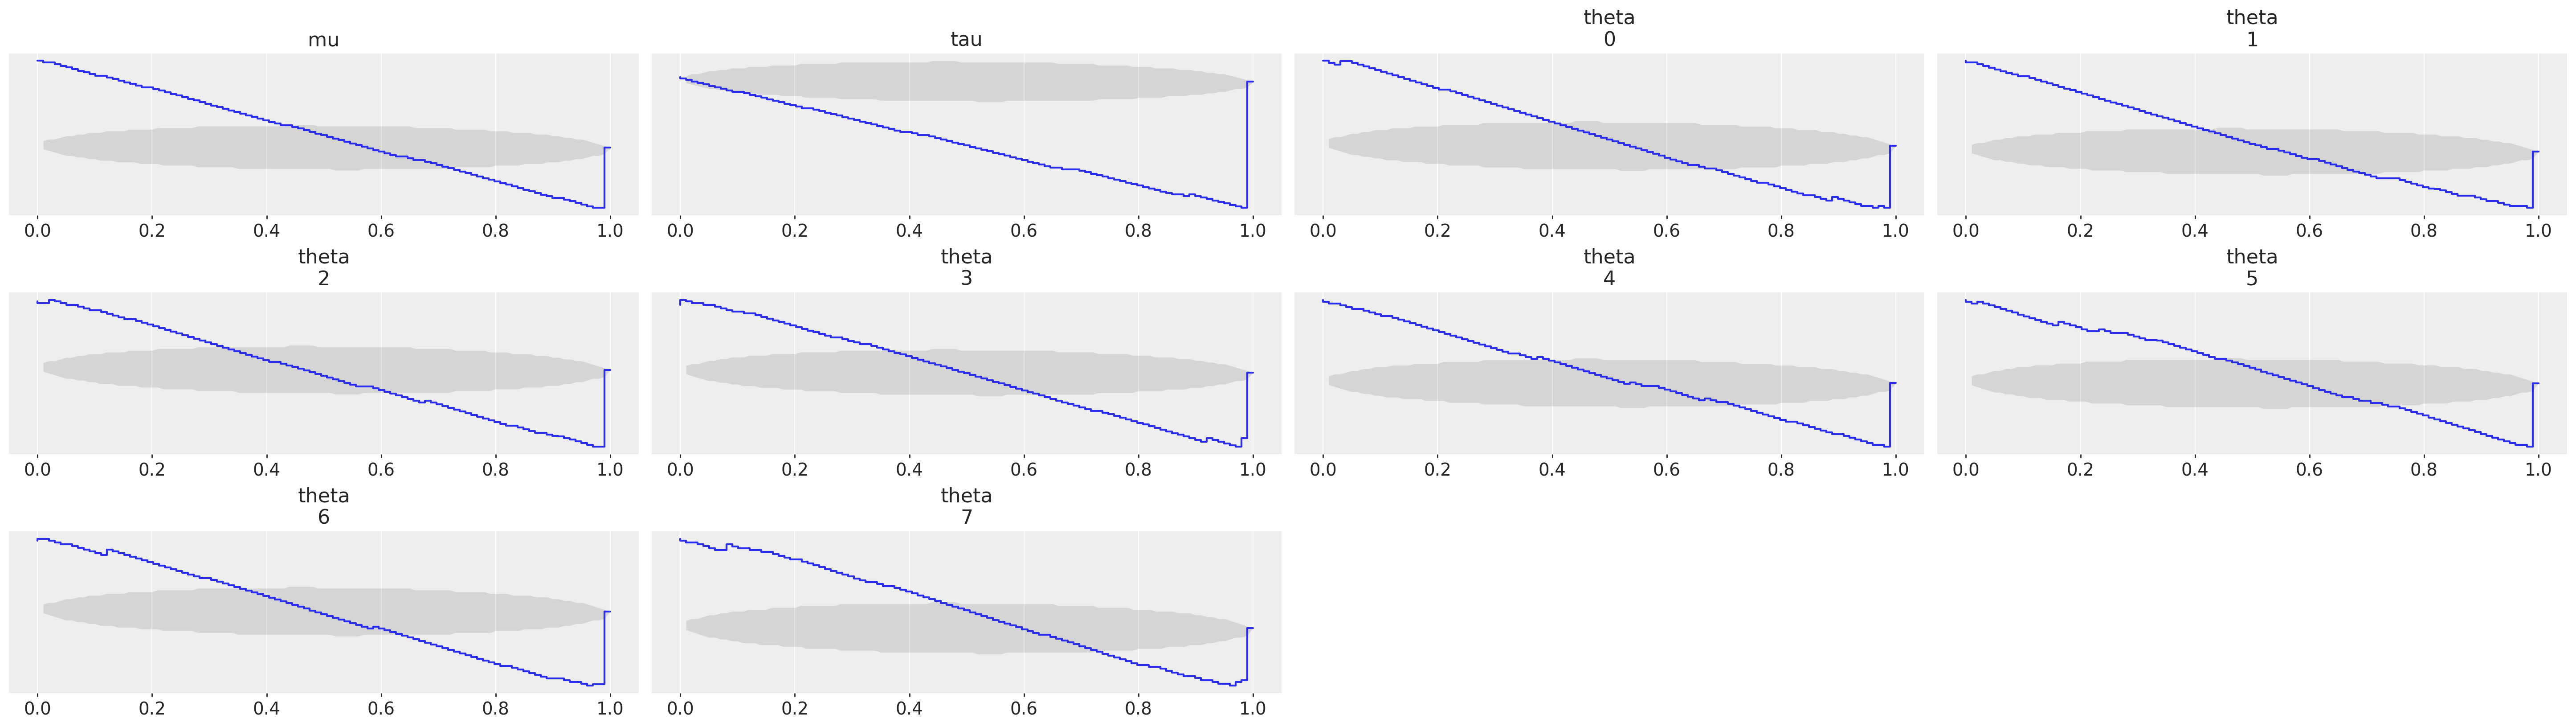

In [20]:
plot_ecdf_pit(
    simulations_svi,
    pc_kwargs={"col_wrap": 4},
    plot_kwargs={"xlabel": False},
)